In [242]:
#%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt

from matplotlib.pyplot import cm 

import numpy as np
import pandas as pd
import fileinput
import re

from io import StringIO
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error, mean_absolute_error
import ipywidgets as widgets
from ipywidgets import interact, IntRangeSlider, Layout, fixed
import seaborn as sns

import collections

import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

# Data Transformation and Features Engineering Section

In [243]:
colnames = ["id","cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7",
           "s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"]

In [19]:
def move_col_last(df,col_name):
  return pd.concat([df.drop(col_name,axis=1),df[col_name]], axis=1)

def move_col_first(df,col_name):
  return pd.concat([df[col_name],df.drop(col_name,axis=1)], axis=1)

def sort_dict(d):
  return dict(sorted(d.items(), key=lambda x: x[1]))

RangeSlider = widgets.IntRangeSlider(
    value=[8311,8391],
    min=1,
    max=100,
    step=10,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    height=3,
    layout=Layout(width='90%', height='50px'),)

def scaler(arr):
  scaler = MinMaxScaler()
  return pd.DataFrame(scaler.fit_transform(pd.DataFrame(arr)))

def Y_ploter(Range,Y):
  start, end = Range
  range_len = end-start
  
  plt.figure(figsize=(16,10))
  
  # pick colors
  colors = cm.rainbow(np.linspace(0, 1, len(Y)))

  for y,color in zip(Y.items(),colors):
    plt.scatter(np.arange(start, end, 1),y[1][start:end], c=color, s=30/(range_len/80),alpha=0.5, label=y[0])

  plt.grid()
  plt.xlabel("%s data points\n range [%s:%s]" % (end-start,start,end))
  plt.ylabel("GT Cycles and Predicted Cycles")
  plt.title(" vs ".join([s for s in Y.keys()]))
  lgnd = plt.legend(scatterpoints=1, fontsize=14)
  for handle in lgnd.legendHandles:
    handle.set_sizes([30])
  plt.show()

def general_data_ploter(Range,Xs,y,scale_y):
  start, end = Range
  range_len = end-start
  
  plt.figure(figsize=(13,10))
  
  # pick colors
  colors = cm.rainbow(np.linspace(0, 1, len(Xs)))
  
  for X,color in zip(Xs,colors):
    # Get label
    label = pd.DataFrame(X).columns[0]
    if(label == 0):
      label = 'y'
    plt.scatter(np.arange(start, end, 1),X[start:end], c=color, s=30/(range_len/80),alpha=0.5, label=label)

  if(scale_y):
    y = scaler(y)

  plt.grid()
  plt.xlabel("sample numbers\n%s data points\n range [%s:%s]" % (end-start,start,end))
  plt.ylabel("Cycles and sensors values (Scalled)")
  plt.title("Scalled Data and Cycles")
  lgnd = plt.legend(scatterpoints=1, fontsize=14)
  for handle in lgnd.legendHandles:
    handle.set_sizes([30])
  plt.show()
  
def bar_chart(scores,title):
  plt.figure(figsize=(13,5))
  values = np.array(list(scores.values()))
  keys = list(scores.keys())  
  colors = cm.tab20c(np.linspace(0, 1, len(scores)))
  plt.bar(range(len(scores)), values, align='center',color=colors)
  for a,b in zip(range(len(scores)), values):
    plt.text(a, b, str(b))
  plt.xticks(range(len(scores)), keys,rotation=45)
  plt.title(title)
  plt.figure()

In [224]:
def transfer_data(file_path,col_names,truth_file=None,features=[],shuffle=False,test_records_only=False,with_id=False):
  # user defined variables to set the windows for classifcation
  w1 = 30
  w0 = 15
  # window size (window_size>=2),  most recent sensor values
  window_size = 5
  
  # read in the file
  with open(file_path, 'r') as f:
    filedata = f.read()
  
  # remove white space from the end of line
  filedata = re.sub('\s*$', '',filedata,flags = re.M)
  
  # filedata is a string that pretends to be a file input
  file_as_string = StringIO(filedata)

  dataset = pd.read_table(file_as_string,sep=" ",names=colnames)
  
  # get the maximum cycle number for each id
  d1 = dataset.groupby(["id"])["cycle"].max().to_frame()
  d1.columns = ['max']

  # add column with the name 'id' (just copy the index)
  d1['id'] = d1.index
  d2 = pd.merge(dataset, d1, on='id')
  
  # generate the column RUL based on the values of columns "max" and "cycle"
  d2['RUL'] = d2['max'] - d2['cycle']

  # exclude column "max" from the data frame
  d2 = d2.drop('max', 1)

  # genearte label1 and label2
  dataset = d2
  dataset['label1'] = np.where(d2['RUL'] <= w1, 1, 0)
  dataset['label2'] = np.where(d2['RUL'] <= w0, 2, (np.where(d2['RUL'] <= w1,1,0)))
  
  # exclude comuns id, cycle, setting1,setting2,setting3, and last 3 columns
  # only the 21 sensor columns are kept in the data frame
  n_pre_sensor_columns = 5 # id, cycle, setting1,setting2,setting3
  n_after_sensor_columns = 3 #RUL, label1, label2
  n_col = len(dataset.columns)

  data = dataset[dataset.columns[n_pre_sensor_columns:n_col - n_after_sensor_columns]]
  n_sensor=len(data.columns)

  ids = dataset.id.unique()
  n_id = len(ids) # 100

  a = ["a" + str(i) for i in range(1,n_sensor+1)] # average
  sd = ["sd" + str(i) for i in range(1,n_sensor+1)] # standard deviation
  diffA = ["diffA" + str(i) for i in range(1,n_sensor+1)] # diff
  diffB = ["diffB" + str(i) for i in range(1,n_sensor+1)] # diff
  diffC = ["diffC" + str(i) for i in range(1,n_sensor+1)] # diff
  
  df = None
  subsets = []
  subset_rolling_mean = pd.DataFrame()
  subset_rolling_std = pd.DataFrame()
  subset_rolling_diffA = pd.DataFrame()
  subset_rolling_diffB = pd.DataFrame()
  subset_rolling_diffC = pd.DataFrame()
  for i in range(1,n_id+1):
    # get the subset of the data that only contains the sensor columns for the id i
    if 'avg' in features:
      subset_rolling_mean = data[dataset.id==i].rolling(window_size,axis=0,min_periods=1).mean()
      subset_rolling_mean.columns = a
      subsets.append(subset_rolling_mean)
    if 'std' in features:
      subset_rolling_std = data[dataset.id==i].rolling(window_size,axis=0,min_periods=1).std().fillna(0)
      subset_rolling_std.columns = sd
    if 'diffA' in features:
      subset_rolling_diffA = data[dataset.id==i].diff(1).fillna(0)
      subset_rolling_diffA.columns = diffA
    if 'diffB' in features:
      subset_rolling_diffB = data[dataset.id==i].diff(1).fillna(0)
      subset_rolling_diffB.columns = diffB
    if 'diffC' in features:
      subset_rolling_diffC = data[dataset.id==i].diff(1).fillna(0)
      subset_rolling_diffC.columns = diffC

    subset = pd.concat([subset_rolling_mean,subset_rolling_std,subset_rolling_diffA,subset_rolling_diffB,subset_rolling_diffC], axis=1)
    df_tmp = pd.concat([dataset[dataset.id == i],subset], axis=1)
    df_tmp = move_col_last(df_tmp,['RUL', 'label1','label2'])

    if df is None:
      df = df_tmp
    else:
      df = df.append(df_tmp,ignore_index=True)

  
  if (shuffle):
    df = df.sample(frac=1)
      
  id_col = df[['id']]
  # Exclude column names: 'id','RUL','label1','label2'
  exclude = ['id','RUL','label1','label2']  
  X = df.drop(exclude, 1)
  y = df['RUL']
  
  
  scaler = MinMaxScaler()
  X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
  
  if (with_id):
    X['id'] = id_col[['id']]
    X = move_col_first(col_name='id',df=X)
  
  # Drop columns which have same values in all rows
  X = X.drop(X.std()[(X.std() == 0)].index, axis=1)
  
  if test_records_only:
    X['id'] = id_col['id']
    X = move_col_first(col_name='id',df=X)
    X = X.loc[X.reset_index().groupby(["id"])["cycle"].idxmax()]
    y = pd.read_csv(truth_file,header=None).rename(columns={0:'RUL'})['RUL']
    print(len(y))
    X = X.drop(['id'],1)
  
  return X,y.as_matrix()

In [225]:
# RUL_FD001.txt
# RUL_FD002.txt
# RUL_FD003.txt
# RUL_FD004.txt

# test_FD001.txt
# test_FD002.txt
# test_FD003.txt
# test_FD004.txt

# train_FD001.txt
# train_FD002.txt
# train_FD003.txt
# train_FD004.txt

RUL_txt1 = "./Data/RUL_FD001.txt"
test_txt1 = "./Data/test_FD001.txt"
train_txt1 = "./Data/train_FD001.txt"

RUL_txt2 = "./Data/RUL_FD002.txt"
test_txt2 = "./Data/test_FD002.txt"
train_txt2 = "./Data/train_FD002.txt"

RUL_txt3 = "./Data/RUL_FD003.txt"
test_txt3 = "./Data/test_FD003.txt"
train_txt3 = "./Data/train_FD003.txt"

RUL_txt4 = "./Data/RUL_FD004.txt"
test_txt4 = "./Data/test_FD004.txt"
train_txt4 = "./Data/train_FD004.txt"

features=['avg','std']

In [227]:
X_train1, y_train1 = transfer_data(
  train_txt1,
  colnames,
  features=features,
  shuffle=True
)

X_test1, y_test1 = transfer_data(
  test_txt1,
  colnames,
  truth_file=RUL_txt1,
  features=features,
  shuffle=False,
  test_records_only=True
)

100


In [228]:
X_train2, y_train2 = transfer_data(
  train_txt2,
  colnames,
  features=features,
  shuffle=True
)

X_test2, y_test2 = transfer_data(
  test_txt2,
  colnames,
  truth_file=RUL_txt2,
  features=features,
  shuffle=False,
  test_records_only=True
)

259


In [229]:
X_train3, y_train3 = transfer_data(
  train_txt3,
  colnames,
  features=features,
  shuffle=True
)

X_test3, y_test3 = transfer_data(
  test_txt3,
  colnames,
  truth_file=RUL_txt3,
  features=features,
  shuffle=False,
  test_records_only=True
)

100


In [230]:
X_train4, y_train4 = transfer_data(
  train_txt4,
  colnames,
  features=features,
  shuffle=True
)

Xtest_4, ytest_4 = transfer_data(
  test_txt4,
  colnames,
  truth_file=RUL_txt4,
  features=features,
  shuffle=False,
  test_records_only=True
)

248


In [91]:
# Xg, yg = transfer_data(train_txt,colnames,features=features,shuffle=False,with_id=True)
# Xgg, ygg = transfer_data(test_txt,colnames,features=features,shuffle=False,with_id=True)

In [231]:
params1 = {
  'loss':'huber',
  'learning_rate':0.15,
  'max_leaf_nodes':16,
  'n_estimators':11,
  }

clf1 = GradientBoostingRegressor(**params1)

clf1.fit(X_train1, y_train1)

mae = mean_absolute_error(y_test1,clf1.predict(X_test1))
print("MAE: %.4f" % mae)

MAE: 17.3576


In [232]:
clf = clf1
params = params1
X_train, y_train = X_train1, y_train1
X_test, y_test = X_test1, y_test1

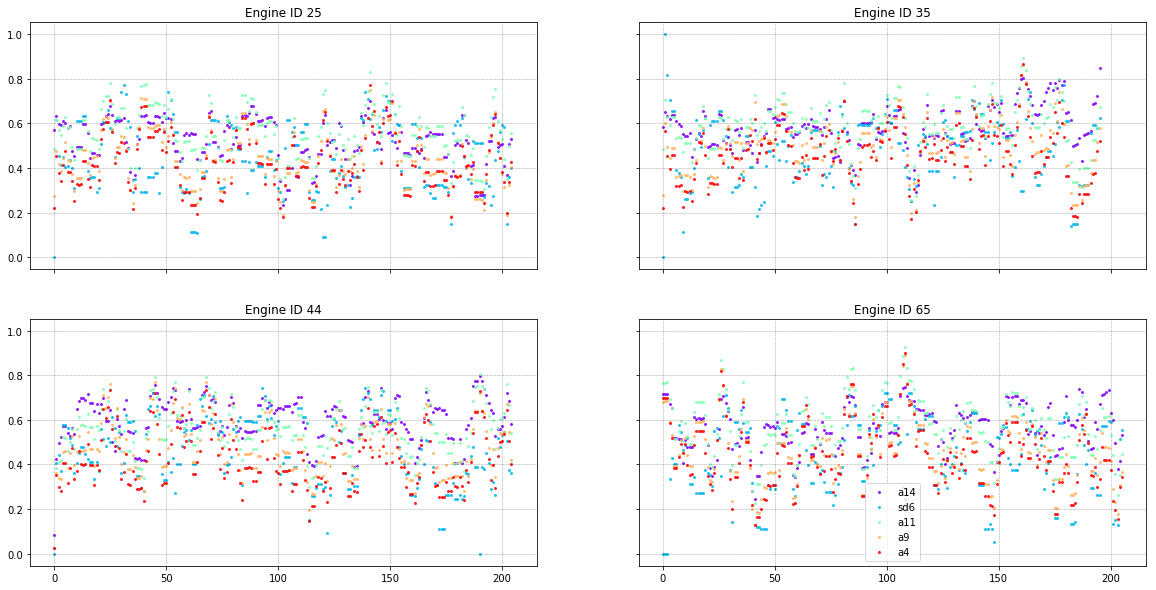

In [233]:
df = Xg
ids = [25,35,44,65]

f, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 10), sharex=True, sharey=True)

for eng,ax in zip(ids,axes.flat):
  cols = ['a14','sd6','a11','a9','a4']
  e = df[df.id == eng]
  color=iter(cm.rainbow(np.linspace(0,1,len(cols))))
  for col in cols:
    ax.scatter(np.arange(0, len(e), 1),e[col], c=next(color), s=4,alpha=0.8)
    ax.set_title("Engine ID {}".format(eng))
    ax.grid(color='k', linestyle='--', linewidth=0.5,alpha=.4)
    
plt.legend()
plt.show()

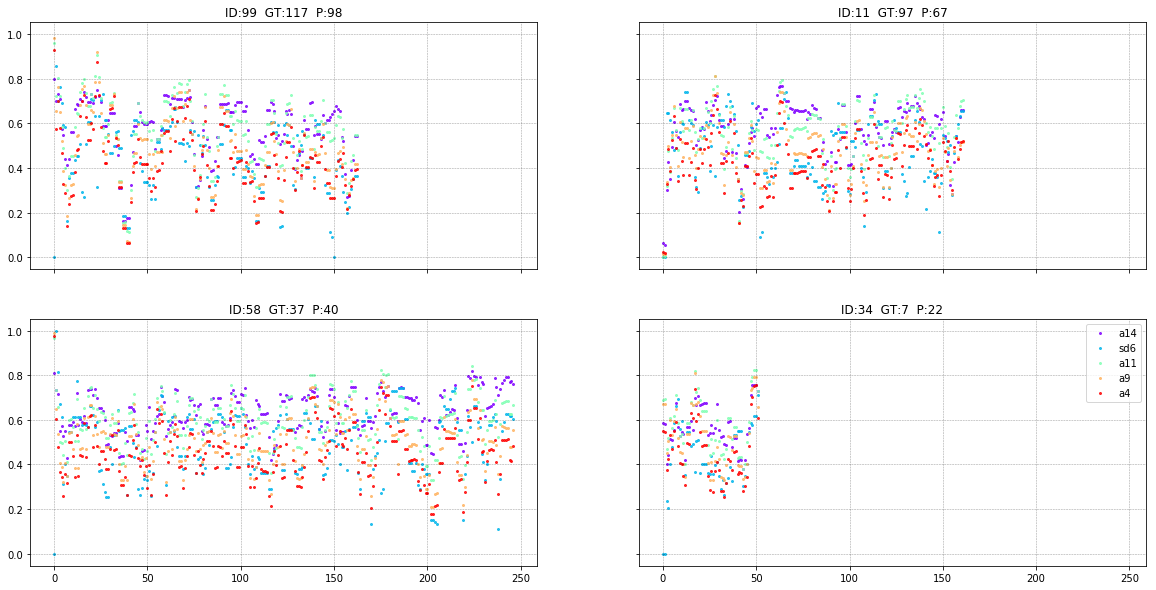

In [240]:
f, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 10), sharex=True, sharey=True)

df = Xgg

results_df = pd.DataFrame({
  "id": range(1,len(clf.predict(X_test))+1),
  "predicted_RUL":clf.predict(X_test),
  "gt_RUL":y_test
})

ids = [99,11,58,34]

for eng_id,ax in zip(ids,axes.flat):
  cols = ['a14','sd6','a11','a9','a4']
  e = df[df.id == eng_id]
  color=iter(cm.rainbow(np.linspace(0,1,len(cols))))
  for col in cols:
    r = results_df[results_df.id==eng_id]
    ax.scatter(np.arange(0, len(e), 1),e[col], c=next(color), s=4,alpha=0.8)
    ax.set_title("ID:{}  GT:{}  P:{}".format(eng_id,int(r.gt_RUL),int(r.predicted_RUL)))
    ax.grid(color='k', linestyle='--', linewidth=0.5,alpha=.4)

plt.legend()
plt.show()

Min error = 240.41309803479353 at iteration 9


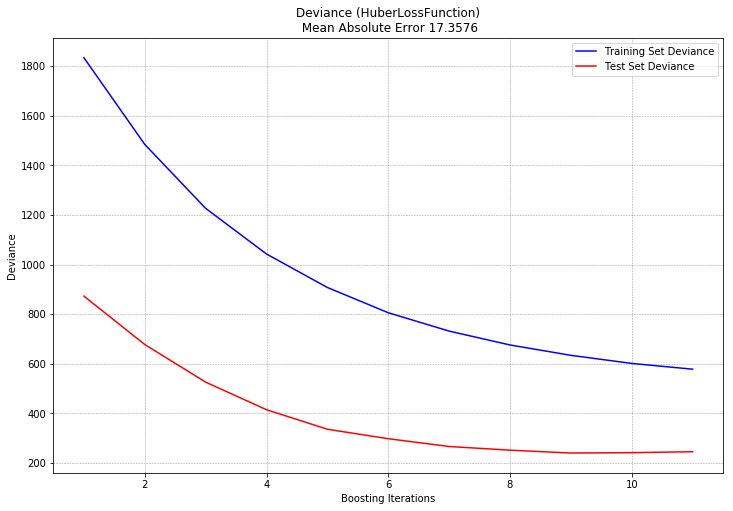

In [241]:
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)


for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred,)


index_min = min(range(len(test_score)), key=test_score.__getitem__)
print("Min error = %s at iteration %s" % (test_score[index_min],index_min+1)) 

plt.figure(figsize=(12, 8))
#plt.subplot(1, 2, 1)
plt.title("Deviance (HuberLossFunction)\n Mean Absolute Error %.4f" % mae)
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.grid(color='k', linestyle='--', linewidth=0.5,alpha=.4)
plt.show()

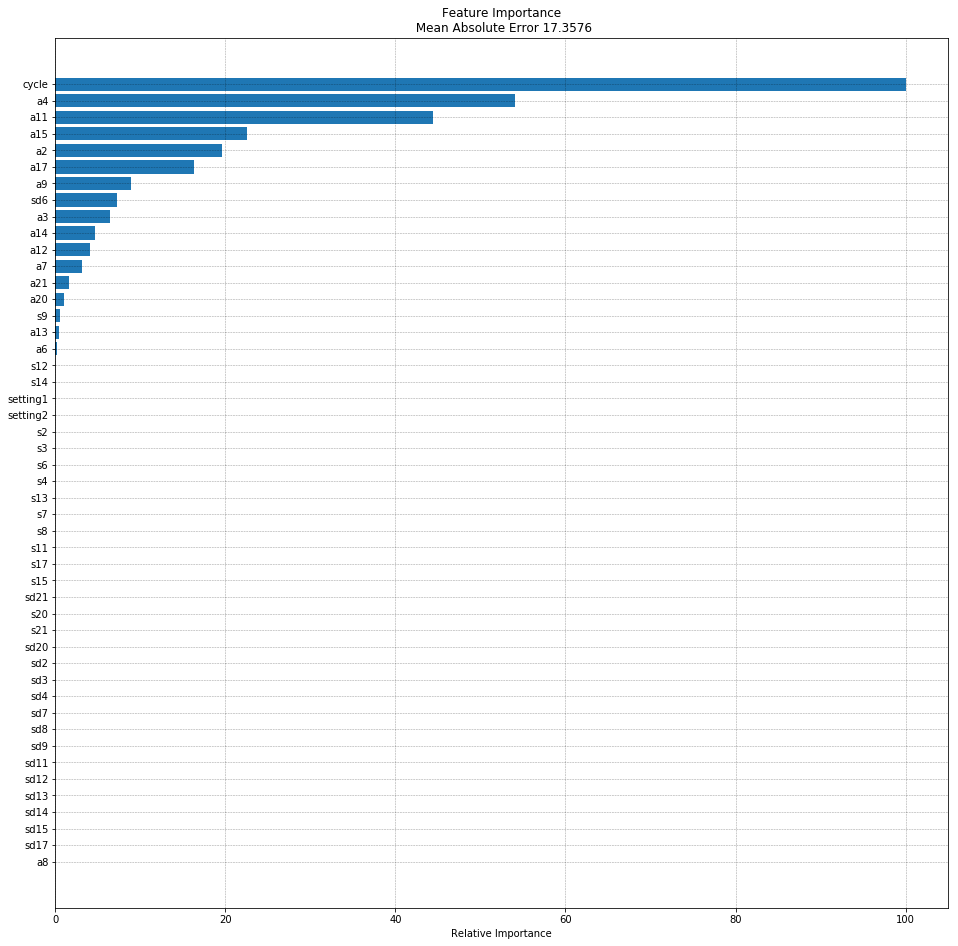

In [236]:

feature_importance = clf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(16, 16))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title("Feature Importance\n Mean Absolute Error %.4f" % mae)
plt.grid(color='k', linestyle='--', linewidth=0.5,alpha=.4)
plt.show()

Min error = 17.35761252876198 at iteration 11


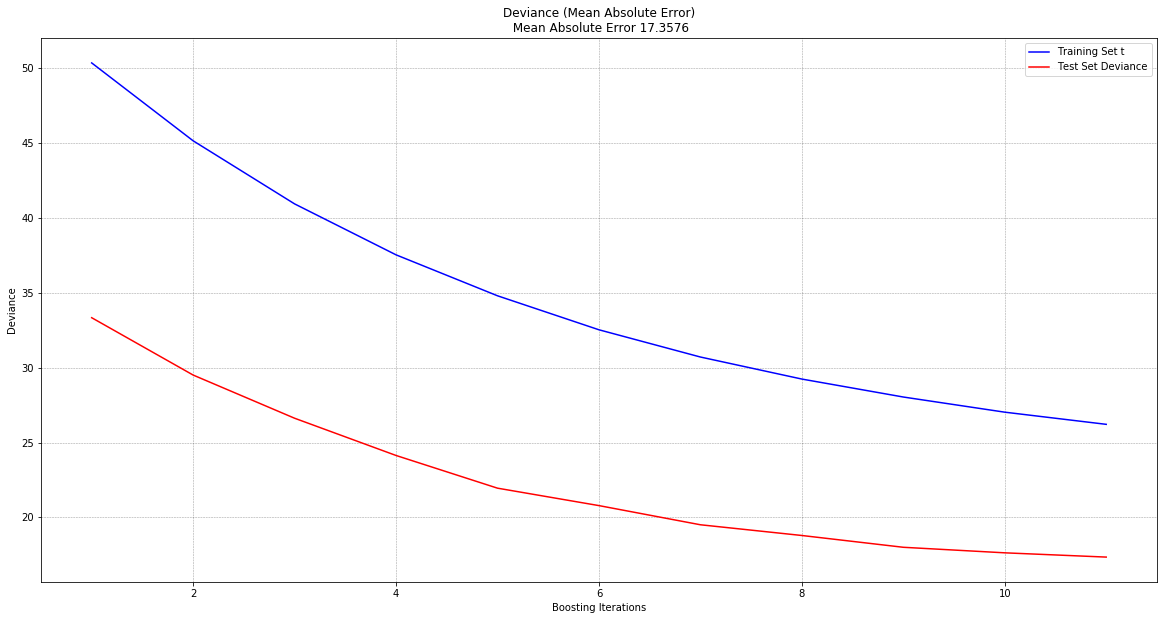

In [237]:
# compute test set deviance
test_score_mae = np.zeros((params['n_estimators'],), dtype=np.float64)
train_score_mae = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
  test_score_mae[i] = mean_absolute_error(y_test,y_pred)
  
for i, y_pred in enumerate(clf.staged_predict(X_train)):
  train_score_mae[i] = mean_absolute_error(y_train,y_pred)
  
mae = mean_absolute_error(y_test,clf.predict(X_test))

index_min = min(range(len(test_score_mae)), key=test_score_mae.__getitem__)
print("Min error = %s at iteration %s" % (test_score_mae[index_min],index_min+1)) 

plt.figure(figsize=(20, 10))
plt.title("Deviance (Mean Absolute Error)\n Mean Absolute Error %.4f" % mae)
plt.plot(np.arange(params['n_estimators']) + 1, train_score_mae, 'b-',label='Training Set t')
plt.plot(np.arange(params['n_estimators']) + 1, test_score_mae, 'r-',label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.grid(color='k', linestyle='--', linewidth=0.5,alpha=.4)
plt.show()

In [238]:
params

{'learning_rate': 0.15,
 'loss': 'huber',
 'max_leaf_nodes': 16,
 'n_estimators': 11}